In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.05

klin =0

nband = 320

ng =10

ng_adju = (/ -2 , -2 /) 

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 20

option_compute_ktable =1

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

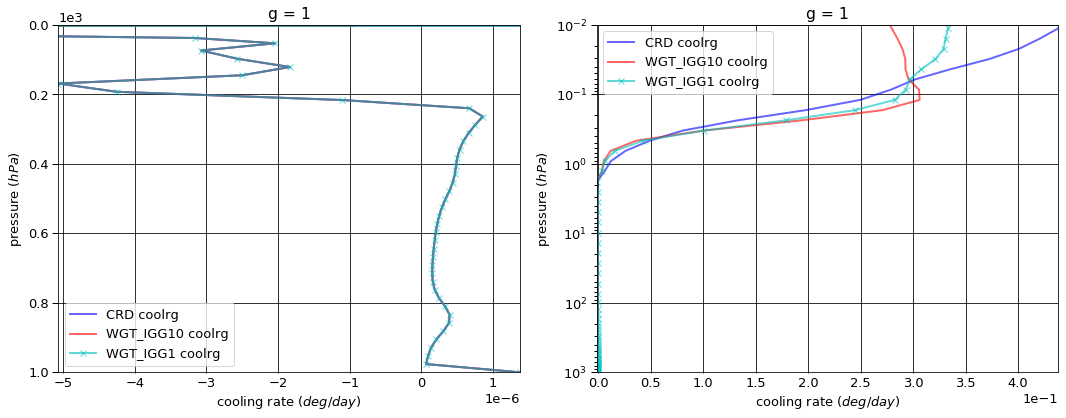

# Figure: cooling rate g-group 2

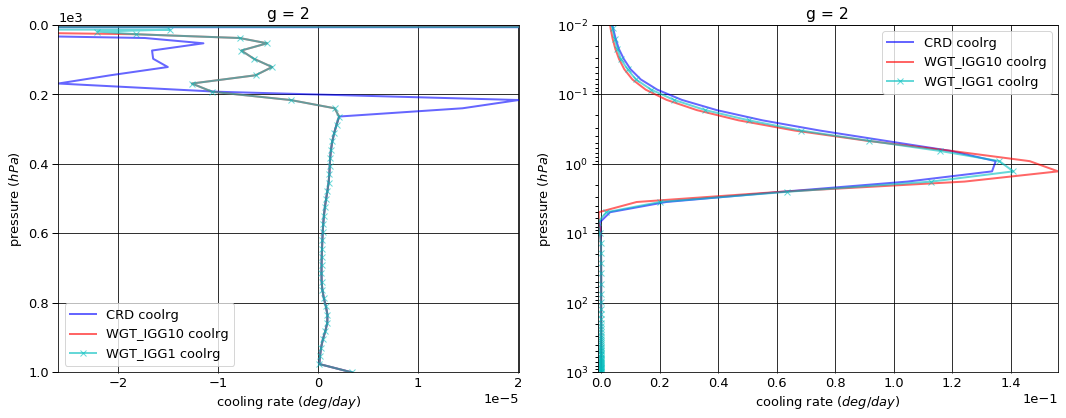

# Figure: cooling rate g-group 3

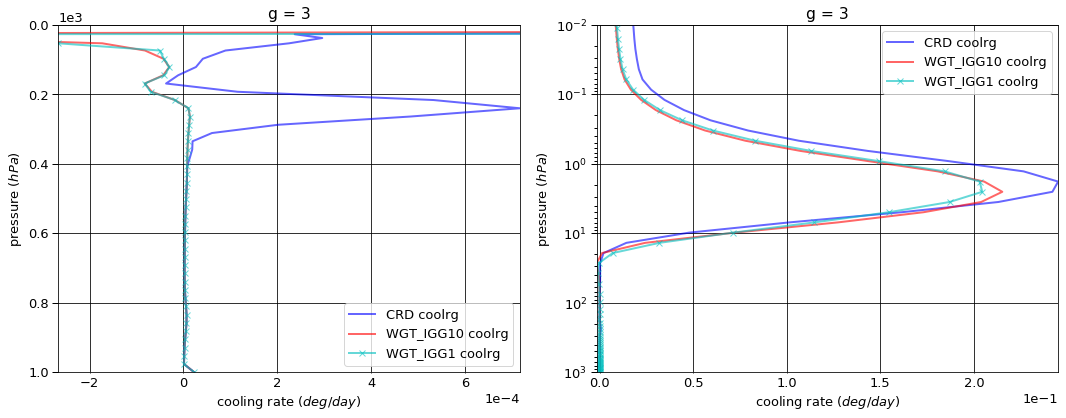

# Figure: cooling rate g-group 4

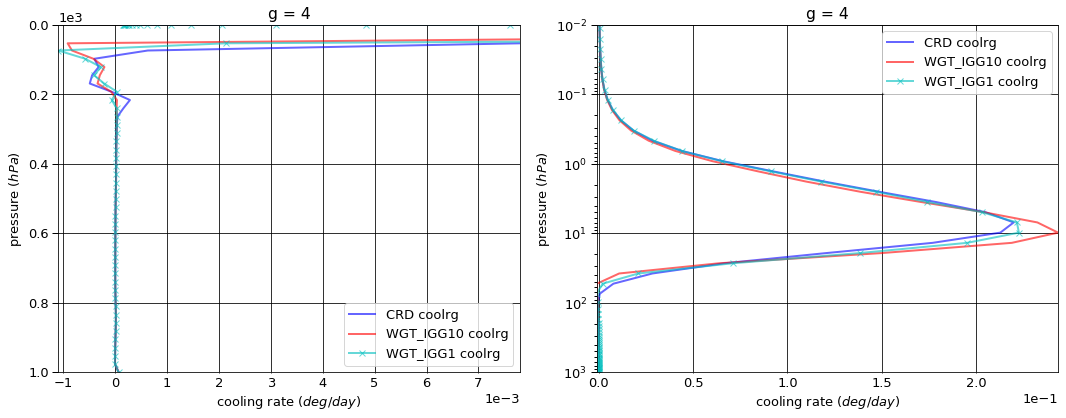

# Figure: cooling rate g-group 5

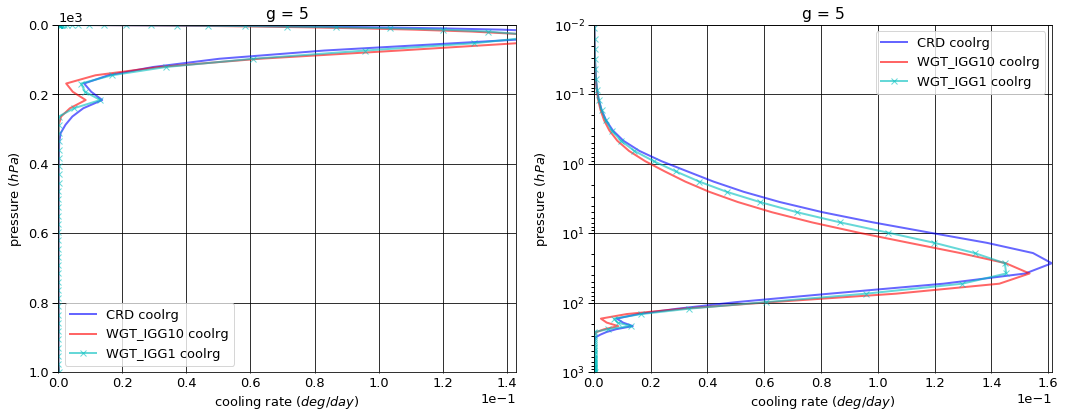

# Figure: cooling rate g-group 6

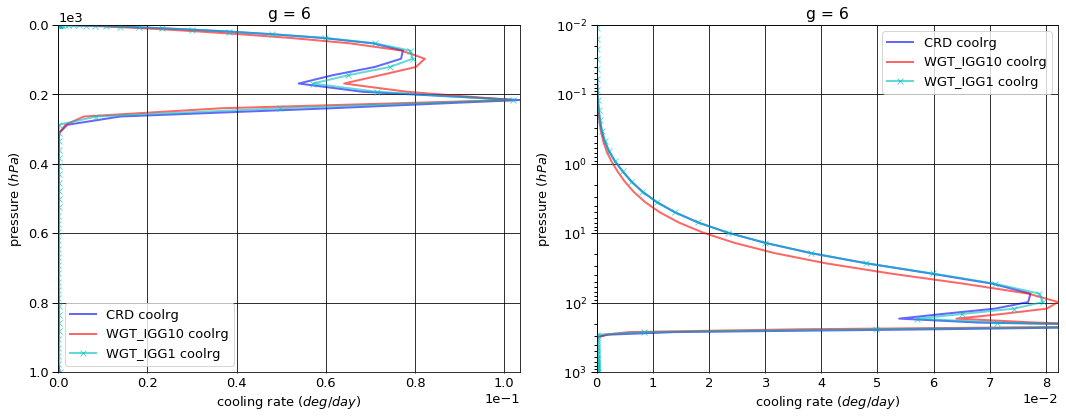

# Figure: cooling rate g-group 7

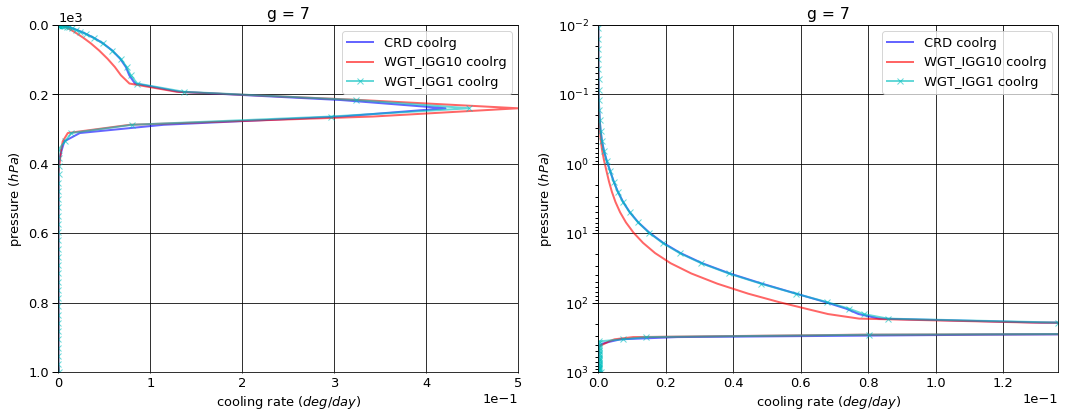

# Figure: cooling rate g-group 8

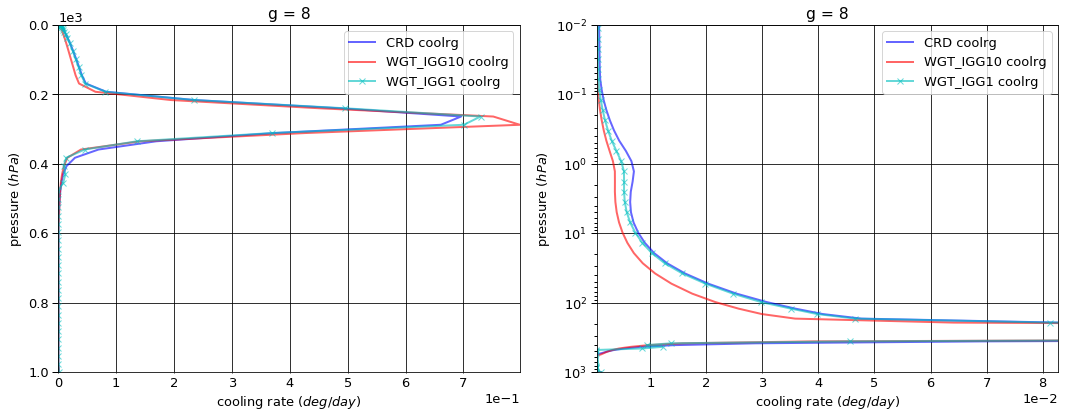

# Figure: cooling rate g-group 9

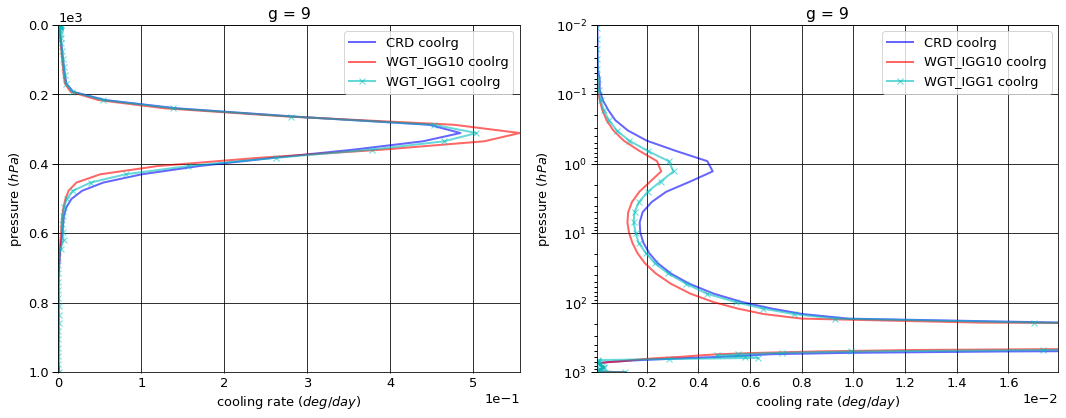

# Figure: cooling rate g-group 10

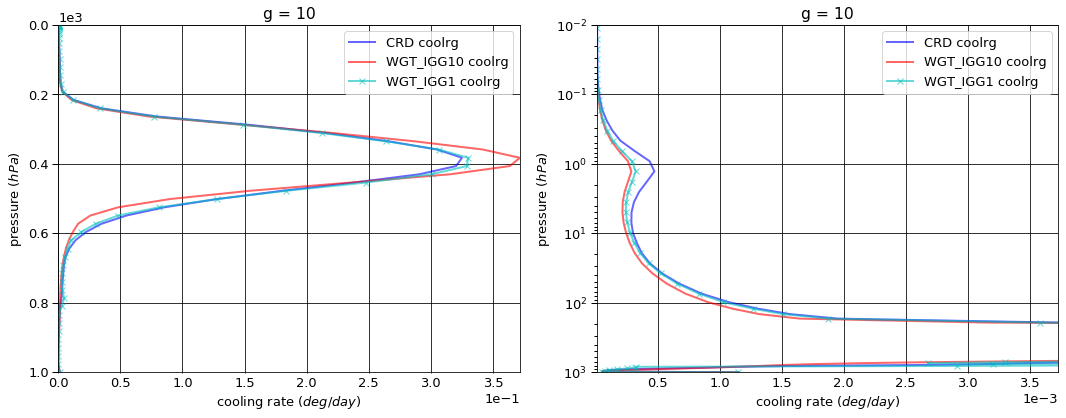

# Figure: cooling rate g-group total

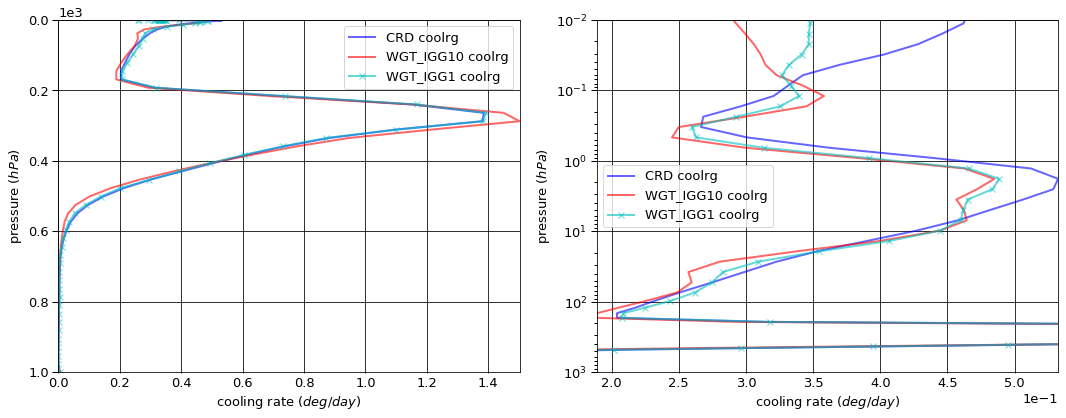

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.011066   0.000000 -0.011066
   1013.0   76     -0.016334   0.016330 -0.000004
2  0.0      1      -0.035572   0.000000 -0.035572
   1013.0   76     -0.041571   0.041561 -0.000009
3  0.0      1      -0.193936   0.000000 -0.193936
   1013.0   76     -0.254124   0.254060 -0.000063
4  0.0      1      -0.561263   0.000000 -0.561263
   1013.0   76     -0.823804   0.823599 -0.000205
5  0.0      1      -1.606171   0.000000 -1.606171
   1013.0   76     -2.587031   2.586399 -0.000632
6  0.0      1      -2.020697   0.000000 -2.020697
   1013.0   76     -3.319097   3.318287 -0.000809
7  0.0      1      -4.970966   0.000000 -4.970966
   1013.0   76     -7.904963   7.903007 -0.001956
8  0.0      1      -8.624639   0.000000 -8.624639
   1013.0   76    -12.999873  12.996648 -0.003225
9  0.0      1      -8.287071   0.000000 -8.287071
   1013.0   76    -12.073331  12.070087 -0.003244
10 0.0      1      -7.921936   0.000000 -7.921936
   1013.0   76    -11.053301  11.050107 -0.003194


WGT_IGG10


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.011108   0.000000 -0.011108
   1013.0   76     -0.016334   0.016330 -0.000004
2  0.0      1      -0.035864   0.000000 -0.035864
   1013.0   76     -0.041571   0.041561 -0.000009
3  0.0      1      -0.193550   0.000000 -0.193550
   1013.0   76     -0.254124   0.254060 -0.000063
4  0.0      1      -0.566155   0.000000 -0.566155
   1013.0   76     -0.823804   0.823599 -0.000205
5  0.0      1      -1.591903   0.000000 -1.591903
   1013.0   76     -2.587031   2.586399 -0.000632
6  0.0      1      -2.008399   0.000000 -2.008399
   1013.0   76     -3.319097   3.318287 -0.000809
7  0.0      1      -4.976637   0.000000 -4.976637
   1013.0   76     -7.904963   7.903007 -0.001956
8  0.0      1      -8.656507   0.000000 -8.656507
   1013.0   76    -12.999873  12.996648 -0.003225
9  0.0      1      -8.241107   0.000000 -8.241107
   1013.0   76    -12.073331  12.070087 -0.003244
10 0.0      1      -7.866118   0.000000 -7.866118
   1013.0   76    -11.053301  11.050119 -0.003182


WGT_IGG1


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.011116   0.000000 -0.011116
   1013.0   76     -0.016334   0.016330 -0.000004
2  0.0      1      -0.035672   0.000000 -0.035672
   1013.0   76     -0.041571   0.041561 -0.000009
3  0.0      1      -0.192214   0.000000 -0.192214
   1013.0   76     -0.254124   0.254060 -0.000063
4  0.0      1      -0.563756   0.000000 -0.563756
   1013.0   76     -0.823804   0.823599 -0.000205
5  0.0      1      -1.594552   0.000000 -1.594552
   1013.0   76     -2.587031   2.586399 -0.000632
6  0.0      1      -2.014564   0.000000 -2.014564
   1013.0   76     -3.319097   3.318287 -0.000809
7  0.0      1      -4.951659   0.000000 -4.951659
   1013.0   76     -7.904963   7.903007 -0.001956
8  0.0      1      -8.601033   0.000000 -8.601033
   1013.0   76    -12.999873  12.996648 -0.003225
9  0.0      1      -8.260632   0.000000 -8.260632
   1013.0   76    -12.073331  12.070087 -0.003244
10 0.0      1      -7.915295   0.000000 -7.915295
   1013.0   76    -11.053301  11.050119 -0.003182


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1     -0.000043  0.000000e+00 -4.254200e-05
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
2  0.0      1     -0.000292  0.000000e+00 -2.920860e-04
   1013.0   76     0.000000  0.000000e+00 -1.694066e-21
3  0.0      1      0.000386  0.000000e+00  3.861600e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1     -0.004892  0.000000e+00 -4.892290e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
5  0.0      1      0.014268  0.000000e+00  1.426750e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
6  0.0      1      0.012299  0.000000e+00  1.229870e-02
   1013.0   76     0.000000  4.440892e-16  0.000000e+00
7  0.0      1     -0.005672  0.000000e+00 -5.671500e-03
   1013.0   76     0.000000 -8.881784e-16  0.000000e+00
8  0.0      1     -0.031869  0.000000e+00 -3.186870e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
9  0.0      1      0.045965  0.000000e+00  4.596460e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
10 0.0      1      0.055818  0.000000e+00  5.581820e-02
   1013.0   76     0.000000  1.200000e-05  1.160710e-05


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1     -0.000050  0.000000e+00 -5.008900e-05
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
2  0.0      1     -0.000100  0.000000e+00 -9.996500e-05
   1013.0   76     0.000000  0.000000e+00 -1.694066e-21
3  0.0      1      0.001722  0.000000e+00  1.722120e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1     -0.002493  0.000000e+00 -2.493080e-03
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
5  0.0      1      0.011619  0.000000e+00  1.161900e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
6  0.0      1      0.006134  0.000000e+00  6.133600e-03
   1013.0   76     0.000000  4.440892e-16  0.000000e+00
7  0.0      1      0.019306  0.000000e+00  1.930650e-02
   1013.0   76     0.000000 -8.881784e-16  0.000000e+00
8  0.0      1      0.023605  0.000000e+00  2.360510e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
9  0.0      1      0.026439  0.000000e+00  2.643920e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
10 0.0      1      0.006641  0.000000e+00  6.641400e-03
   1013.0   76     0.000000  1.200000e-05  1.160710e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.266212e-01
   1001.112500 75     1.372505e-06
2  0.000312    1      1.716314e-03
   1001.112500 75     3.384016e-06
3  0.000312    1      1.588313e-02
   1001.112500 75     2.294942e-05
4  0.000312    1      1.368932e-04
   1001.112500 75     7.415282e-05
5  0.000312    1      5.332796e-05
   1001.112500 75     2.286612e-04
6  0.000312    1      6.689321e-07
   1001.112500 75     2.927347e-04
7  0.000312    1      6.164601e-06
   1001.112500 75     7.073765e-04
8  0.000312    1      7.035071e-04
   1001.112500 75     1.166103e-03
9  0.000312    1      6.135181e-05
   1001.112500 75     1.173040e-03
10 0.000312    1      9.158749e-06
   1001.112500 75     1.155203e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      2.353980e-01
   1001.112500 75     1.372505e-06
2  0.000312    1      1.330283e-03
   1001.112500 75     3.384016e-06
3  0.000312    1      6.913830e-03
   1001.112500 75     2.294942e-05
4  0.000312    1      1.532417e-04
   1001.112500 75     7.415282e-05
5  0.000312    1      5.929894e-05
   1001.112500 75     2.286612e-04
6  0.000312    1      5.436991e-07
   1001.112500 75     2.927347e-04
7  0.000312    1      4.259243e-06
   1001.112500 75     7.073765e-04
8  0.000312    1      3.378987e-04
   1001.112500 75     1.166103e-03
9  0.000312    1      4.328252e-05
   1001.112500 75     1.173040e-03
10 0.000312    1      6.264677e-06
   1001.112500 75     1.150459e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      3.040130e-01
   1001.112500 75     1.372505e-06
2  0.000312    1      1.535410e-03
   1001.112500 75     3.384016e-06
3  0.000312    1      7.329044e-03
   1001.112500 75     2.294942e-05
4  0.000312    1      1.618501e-04
   1001.112500 75     7.415282e-05
5  0.000312    1      6.735934e-05
   1001.112500 75     2.286612e-04
6  0.000312    1      6.702290e-07
   1001.112500 75     2.927347e-04
7  0.000312    1      6.177906e-06
   1001.112500 75     7.073765e-04
8  0.000312    1      4.975504e-04
   1001.112500 75     1.166103e-03
9  0.000312    1      5.269112e-05
   1001.112500 75     1.173040e-03
10 0.000312    1      7.299047e-06
   1001.112500 75     1.150459e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.912232e-01
   1001.112500 75     0.000000e+00
2  0.000312    1     -3.860314e-04
   1001.112500 75     4.235165e-22
3  0.000312    1     -8.969296e-03
   1001.112500 75     0.000000e+00
4  0.000312    1      1.634847e-05
   1001.112500 75     0.000000e+00
5  0.000312    1      5.970982e-06
   1001.112500 75     2.710505e-20
6  0.000312    1     -1.252330e-07
   1001.112500 75     0.000000e+00
7  0.000312    1     -1.905357e-06
   1001.112500 75     0.000000e+00
8  0.000312    1     -3.656084e-04
   1001.112500 75     0.000000e+00
9  0.000312    1     -1.806929e-05
   1001.112500 75     0.000000e+00
10 0.000312    1     -2.894073e-06
   1001.112500 75    -4.743500e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.226082e-01
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.809042e-04
   1001.112500 75     4.235165e-22
3  0.000312    1     -8.554082e-03
   1001.112500 75     0.000000e+00
4  0.000312    1      2.495689e-05
   1001.112500 75     0.000000e+00
5  0.000312    1      1.403138e-05
   1001.112500 75     2.710505e-20
6  0.000312    1      1.296880e-09
   1001.112500 75     0.000000e+00
7  0.000312    1      1.330500e-08
   1001.112500 75     0.000000e+00
8  0.000312    1     -2.059566e-04
   1001.112500 75     0.000000e+00
9  0.000312    1     -8.660687e-06
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.859702e-06
   1001.112500 75    -4.743500e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.233317,0.000000,-34.233317
1013.0,76,-51.073429,51.060087,-0.013342



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.147349,0.000000,-34.147349
1013.0,76,-51.073429,51.060099,-0.013331



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.140493,0.000000,-34.140493
1013.0,76,-51.073429,51.060099,-0.013331



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.085968,0.000000,0.085968
1013.0,76,0.000000,0.000012,0.000012



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.092824,0.000000,0.092824
1013.0,76,0.000000,0.000012,0.000012


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.445192
1001.112500,75,0.004825



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.244247
1001.112500,75,0.004820



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.313671
1001.112500,75,0.004820



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.200945
1001.112500,75,-0.000005



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.131521
1001.112500,75,-0.000005


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000469,0.000331
2,0.001406,0.000849
3,0.005000,0.005042
4,0.018437,0.016362
5,0.061406,0.051655
6,0.080000,0.066314
7,0.180938,0.157270
8,0.289531,0.258439
9,0.214688,0.234217


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.802122e-17
2,1.518658e-18
3,1.279781e-19
4,2.753205e-19
5,2.415716e-20
6,5.547182e-20
7,1.291925e-20
8,3.008862e-21
9,7.007566e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.802122e-17,NaN,0.000469,0.000331,0.000469,0.000331,1.0
2,1.518658e-18,0.084271,0.001406,0.000849,0.001875,0.001180,1.0
3,1.279781e-19,0.084271,0.005000,0.005042,0.006875,0.006222,1.0
4,2.753205e-19,2.151309,0.018437,0.016362,0.025312,0.022583,30.0
5,2.415716e-20,0.087742,0.061406,0.051655,0.086719,0.074238,30.0
6,5.547182e-20,2.296289,0.080000,0.066314,0.166719,0.140552,300.0
7,1.291925e-20,0.232898,0.180938,0.157270,0.347656,0.297822,300.0
8,3.008862e-21,0.232898,0.289531,0.258439,0.637188,0.556261,300.0
9,7.007566e-22,0.232898,0.214688,0.234217,0.851875,0.790479,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
